# 0. Libraries 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from transformers import BertTokenizer, BertModel
from PIL import Image, ImageFile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from tqdm import tqdm
import os
import random

2025-12-13 09:35:55.464438: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765618555.694209      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765618555.758239      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

# 1. UTILS & LOSS FUNCTIONS

In [2]:
# Cho phép load ảnh bị lỗi nhẹ (truncated images)
ImageFile.LOAD_TRUNCATED_IMAGES = True

# ==========================================
# 1. LOSS FUNCTION: BATCH HARD TRIPLET LOSS
# ==========================================
class BatchHardTripletLoss(nn.Module):
    """
    Tính Triplet Loss với chiến lược 'Batch Hard'.
    Chọn cặp Positive xa nhất và Negative gần nhất trong batch để tính loss.
    """
    def __init__(self, margin=0.3):
        super(BatchHardTripletLoss, self).__init__()
        self.margin = margin

    def forward(self, embeddings, labels):
        # Tính ma trận khoảng cách Euclidean: dist[i,j] = ||emb[i] - emb[j]||
        dists = torch.cdist(embeddings, embeddings, p=2)
        
        # Mask Positive (cùng nhãn) và Negative (khác nhãn)
        mask_pos = (labels.unsqueeze(0) == labels.unsqueeze(1))
        mask_neg = ~mask_pos
        
        # Bỏ đường chéo (chính nó) khỏi Positive mask
        eye = torch.eye(labels.size(0)).bool().to(labels.device)
        mask_pos = mask_pos & ~eye
        
        # 1. Hardest Positive: Max distance của cặp cùng loại
        dists_pos = dists * mask_pos.float()
        hardest_pos_dist, _ = dists_pos.max(dim=1)
        
        # 2. Hardest Negative: Min distance của cặp khác loại
        # Gán cặp không phải negative thành vô cùng lớn để hàm min không chọn
        dists_neg = dists + (~mask_neg).float() * 1e9
        hardest_neg_dist, _ = dists_neg.min(dim=1)
        
        # 3. Loss = max(0, pos - neg + margin)
        loss = torch.relu(hardest_pos_dist - hardest_neg_dist + self.margin)
        
        return loss.mean()

# 2. DATASET & TRANSFORMS

In [3]:
# ==========================================
# 2. DATASET & TRANSFORMS
# ==========================================
class FashionDataset(Dataset):
    def __init__(self, df, img_dir, tokenizer, max_len=64, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Load image
        img_path = os.path.join(self.img_dir, row['image'])
        try:
            image = Image.open(img_path).convert('RGB')
        except:
            # Fallback nếu ảnh lỗi (dù đã lọc trước đó)
            image = Image.new('RGB', (224, 224), color='black')

        if self.transform:
            image = self.transform(image)
        
        # Tokenize text
        text = f"{row['display name']} {row['description']}"
        encoding = self.tokenizer.encode_plus(
            str(text).strip(),
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'image': image,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(row['label_idx'], dtype=torch.long),
            'product_id': idx
        }

def get_transforms(is_train=True):
    if is_train:
        # Augmentation mạnh cho tập train
        return transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.RandomResizedCrop(224, scale=(0.85, 1.0)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ColorJitter(brightness=0.1, contrast=0.1),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    else:
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

# 3. MODEL ARCHITECTURE

In [4]:
# ==========================================
# 3. TWO-TOWER MODEL ARCHITECTURE
# ==========================================
class TwoTowerModel(nn.Module):
    def __init__(self, embedding_dim=128):
        super(TwoTowerModel, self).__init__()
        
        # --- Image Tower (ResNet50) ---
        resnet = models.resnet50(pretrained=True)
        self.image_encoder = nn.Sequential(*list(resnet.children())[:-1]) # Output: 2048
        self.image_proj = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512)
        )
        
        # --- Text Tower (BERT) ---
        self.text_encoder = BertModel.from_pretrained('bert-base-uncased')
        self.text_proj = nn.Sequential(
            nn.Linear(768, 768),
            nn.BatchNorm1d(768),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(768, 512)
        )
        
        # --- Fusion ---
        self.fusion = nn.Sequential(
            nn.Linear(512 * 2, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, embedding_dim)
        )
        
    def forward(self, image, input_ids, attention_mask):
        # Image
        img_feat = self.image_encoder(image).squeeze()
        img_emb = self.image_proj(img_feat)
        
        # Text
        text_out = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask)
        text_feat = text_out.pooler_output
        text_emb = self.text_proj(text_feat)
        
        # Fusion
        combined = torch.cat([img_emb, text_emb], dim=1)
        final_emb = self.fusion(combined)
        
        # L2 Normalize (Rất quan trọng cho Triplet Loss/Cosine Similarity)
        final_emb = nn.functional.normalize(final_emb, p=2, dim=1)
        
        return final_emb

    def set_backbone_trainable(self, trainable=False):
        """Freeze/Unfreeze Backbone"""
        for param in self.image_encoder.parameters():
            param.requires_grad = trainable
        for param in self.text_encoder.parameters():
            param.requires_grad = trainable

# 4. METRICS & VISUALIZATION

In [5]:
# ==========================================
# 4. METRICS & VISUALIZATION
# ==========================================

def calculate_metrics(embeddings, labels, k_list=[1, 5, 10]):
    """Tính Recall@K, MRR, NDCG@10"""
    print("Calculating metrics...")
    sim_matrix = np.dot(embeddings, embeddings.T)
    np.fill_diagonal(sim_matrix, -np.inf) # Không so sánh với chính nó
    
    max_k = max(k_list)
    top_k_indices = np.argsort(sim_matrix, axis=1)[:, -max_k:][:, ::-1]
    
    num_samples = len(labels)
    metrics = {f'Recall@{k}': 0.0 for k in k_list}
    metrics['MRR'] = 0.0
    metrics[f'NDCG@{max_k}'] = 0.0
    
    for i in range(num_samples):
        query_lbl = labels[i]
        retrieved_lbls = labels[top_k_indices[i]]
        hits = (retrieved_lbls == query_lbl)
        
        # Recall@K
        for k in k_list:
            if hits[:k].any():
                metrics[f'Recall@{k}'] += 1.0
        
        # MRR
        first_hit = np.where(hits)[0]
        if len(first_hit) > 0:
            metrics['MRR'] += 1.0 / (first_hit[0] + 1)
            
        # NDCG@10
        relevance = hits.astype(int)
        num_rel = np.sum(relevance)
        if num_rel > 0:
            discounts = np.log2(np.arange(len(relevance)) + 2)
            dcg = np.sum(relevance / discounts)
            ideal_rel = np.zeros_like(relevance)
            ideal_rel[:num_rel] = 1
            idcg = np.sum(ideal_rel / discounts)
            metrics[f'NDCG@{max_k}'] += dcg / idcg

    for key in metrics:
        metrics[key] /= num_samples
    return metrics

def visualize_results(train_losses, val_losses, embeddings, labels, df, img_dir, le, num_queries=3):
    sns.set_style("whitegrid")
    
    # 1. Loss History
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss', marker='o')
    plt.plot(val_losses, label='Val Loss', marker='s')
    plt.title('Training Loss History')
    plt.xlabel('Epoch'); plt.ylabel('Loss')
    plt.legend(); plt.grid(True, alpha=0.3)
    plt.savefig('loss_history.png')
    plt.show()
    plt.close()
    
    # 2. t-SNE Plot (Subsample 2000 points, Top 10 Classes)
    print("Generating t-SNE...")
    unique_lbls, counts = np.unique(labels, return_counts=True)
    top_lbls = unique_lbls[np.argsort(counts)[::-1][:10]]
    mask = np.isin(labels, top_lbls)
    
    emb_sub = embeddings[mask]
    lbl_sub = labels[mask]
    if len(emb_sub) > 2000:
        idx = np.random.choice(len(emb_sub), 2000, replace=False)
        emb_sub = emb_sub[idx]
        lbl_sub = lbl_sub[idx]
        
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    tsne_res = tsne.fit_transform(emb_sub)
    
    plt.figure(figsize=(12, 10))
    df_vis = pd.DataFrame({'x': tsne_res[:,0], 'y': tsne_res[:,1], 'Category': le.inverse_transform(lbl_sub)})
    sns.scatterplot(data=df_vis, x='x', y='y', hue='Category', palette='tab10', s=60, alpha=0.8)
    plt.title('t-SNE Embeddings (Top 10 Categories)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('tsne_plot.png')
    plt.show()
    plt.close()
    
    # 3. Retrieval Examples
    print("Generating Retrieval Examples...")
    sim_matrix = np.dot(embeddings, embeddings.T)
    np.fill_diagonal(sim_matrix, -1)
    
    indices = random.sample(range(len(df)), num_queries)
    for idx in indices:
        top_idx = np.argsort(sim_matrix[idx])[::-1][:5]
        query_row = df.iloc[idx]
        
        plt.figure(figsize=(15, 4))
        # Query
        plt.subplot(1, 6, 1)
        q_img = Image.open(os.path.join(img_dir, query_row['image'])).convert('RGB')
        plt.imshow(q_img); plt.axis('off')
        plt.title(f"QUERY\n{query_row['category']}", color='red', fontsize=10)
        
        # Results
        for i, r_idx in enumerate(top_idx):
            res_row = df.iloc[r_idx]
            r_img = Image.open(os.path.join(img_dir, res_row['image'])).convert('RGB')
            score = sim_matrix[idx][r_idx]
            
            plt.subplot(1, 6, i+2)
            plt.imshow(r_img); plt.axis('off')
            color = 'green' if res_row['category'] == query_row['category'] else 'black'
            plt.title(f"{score:.2f}\n{res_row['category']}", color=color, fontsize=9)
            
        plt.tight_layout()
        plt.savefig(f'retrieval_example_{idx}.png')
        plt.show()
        plt.close()

# 5. TRAINING

In [6]:
# ==========================================
# 5. MAIN TRAINING LOOP
# ==========================================

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for batch in tqdm(loader, desc="Train"):
        images = batch['image'].to(device)
        input_ids = batch['input_ids'].to(device)
        mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        optimizer.zero_grad()
        embeddings = model(images, input_ids, mask)
        loss = criterion(embeddings, labels)
        
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0 
    with torch.no_grad():
        for batch in tqdm(loader, desc="Val"):
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            embeddings = model(images, input_ids, mask)
            loss = criterion(embeddings, labels)
            total_loss += loss.item()
    return total_loss / len(loader)

  # 6. MAIN EXECUTION


Using Device: cuda
Loading & Cleaning Data...
Data ready: 44135 items, 128 classes.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 215MB/s]


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]


START TRAINING...
Epoch 1: Backbone Frozen


Val: 100%|██████████| 207/207 [01:28<00:00,  2.34it/s]


Epoch 1 | Train Loss: 0.1647 | Val Loss: 0.1073
>>> Model Saved!
Epoch 2: Backbone Frozen


Val: 100%|██████████| 207/207 [01:15<00:00,  2.75it/s]


Epoch 2 | Train Loss: 0.1274 | Val Loss: 0.0941
>>> Model Saved!
Epoch 3: Backbone Unfrozen


Val: 100%|██████████| 207/207 [01:18<00:00,  2.62it/s]


Epoch 3 | Train Loss: 0.0496 | Val Loss: 0.0190
>>> Model Saved!
Epoch 4: Backbone Unfrozen


Val: 100%|██████████| 207/207 [01:18<00:00,  2.63it/s]


Epoch 4 | Train Loss: 0.0237 | Val Loss: 0.0185
>>> Model Saved!
Epoch 5: Backbone Unfrozen


Val: 100%|██████████| 207/207 [01:20<00:00,  2.57it/s]


Epoch 5 | Train Loss: 0.0184 | Val Loss: 0.0133
>>> Model Saved!
Epoch 6: Backbone Unfrozen


Val: 100%|██████████| 207/207 [01:18<00:00,  2.65it/s]


Epoch 6 | Train Loss: 0.0149 | Val Loss: 0.0137

BUILDING EMBEDDINGS & EVALUATING...


100%|██████████| 690/690 [08:37<00:00,  1.33it/s]


Calculating metrics...

FINAL METRICS:
Recall@1: 0.9703
Recall@5: 0.9884
Recall@10: 0.9914
MRR: 0.9784
NDCG@10: 0.9794


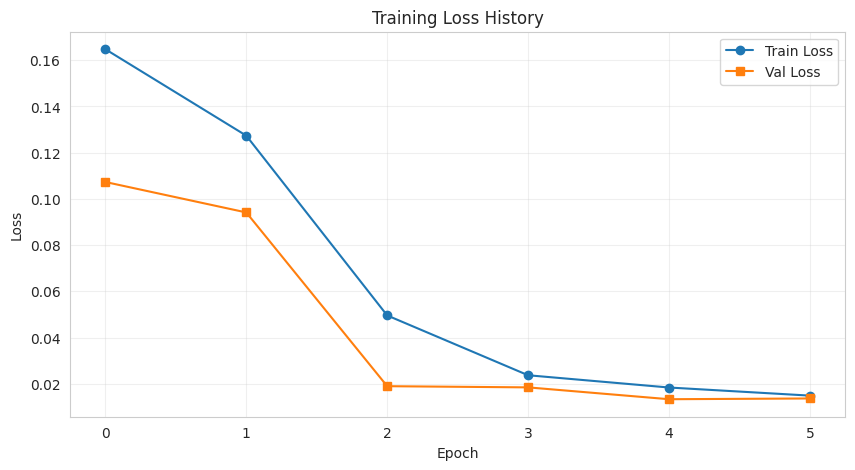

Generating t-SNE...


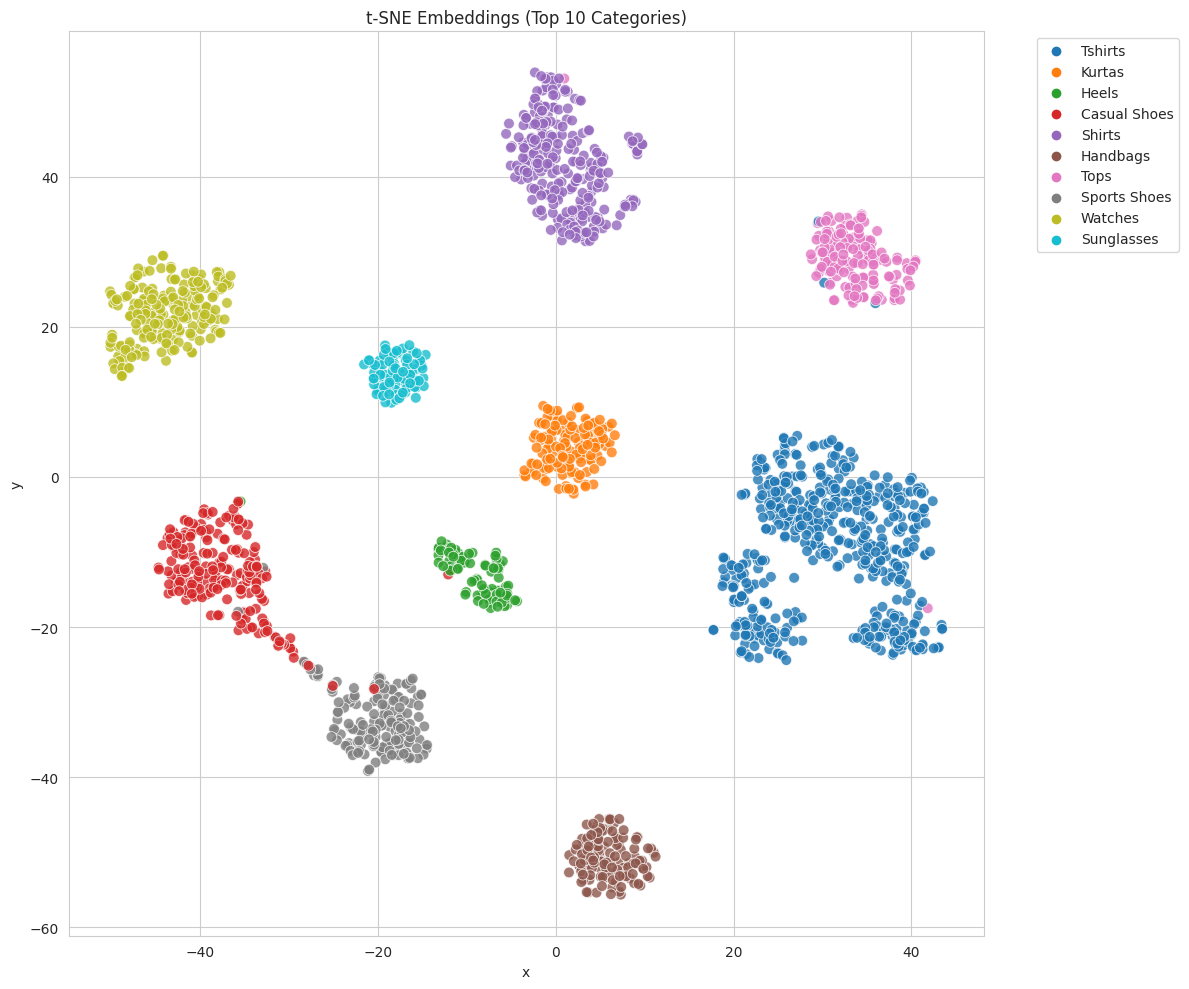

Generating Retrieval Examples...


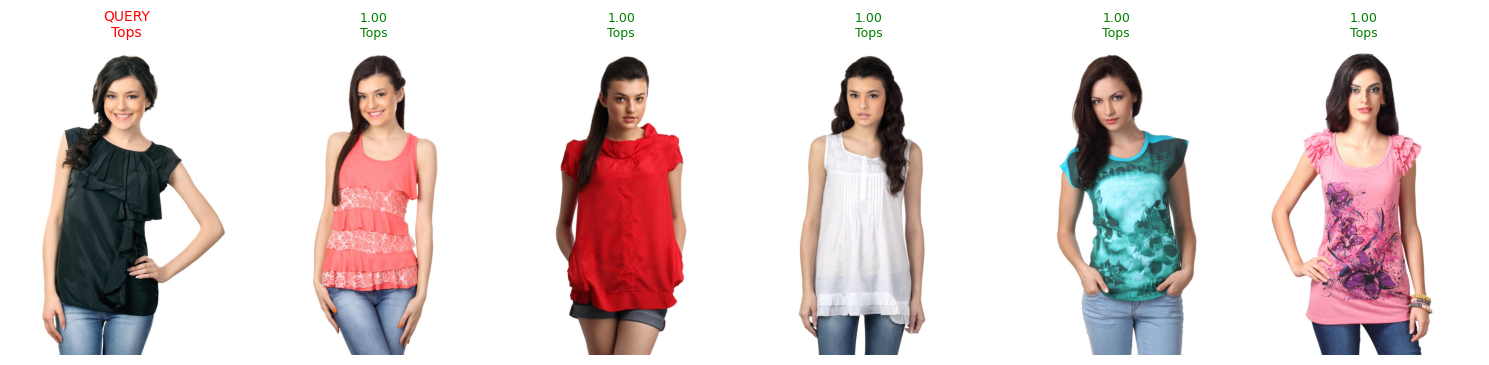

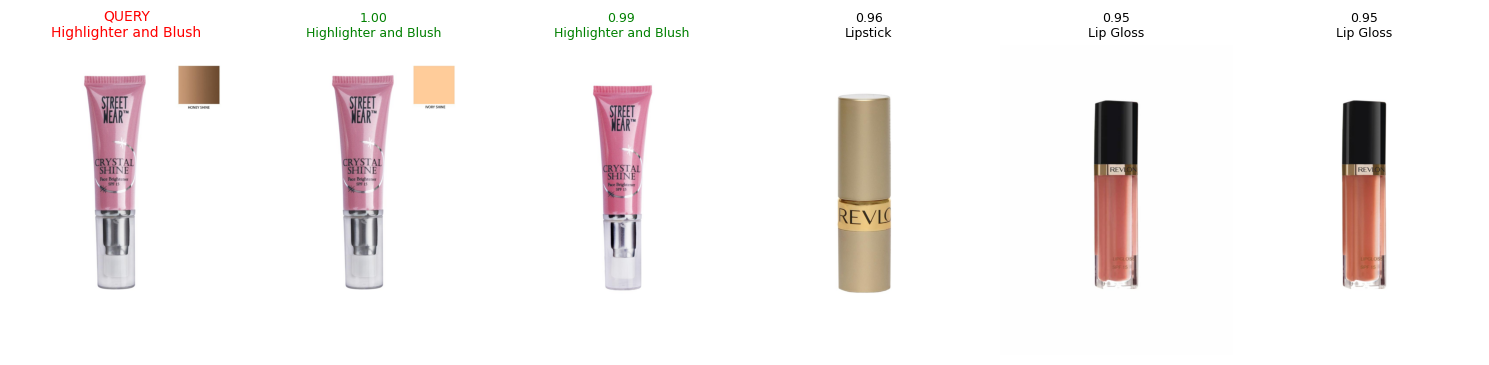

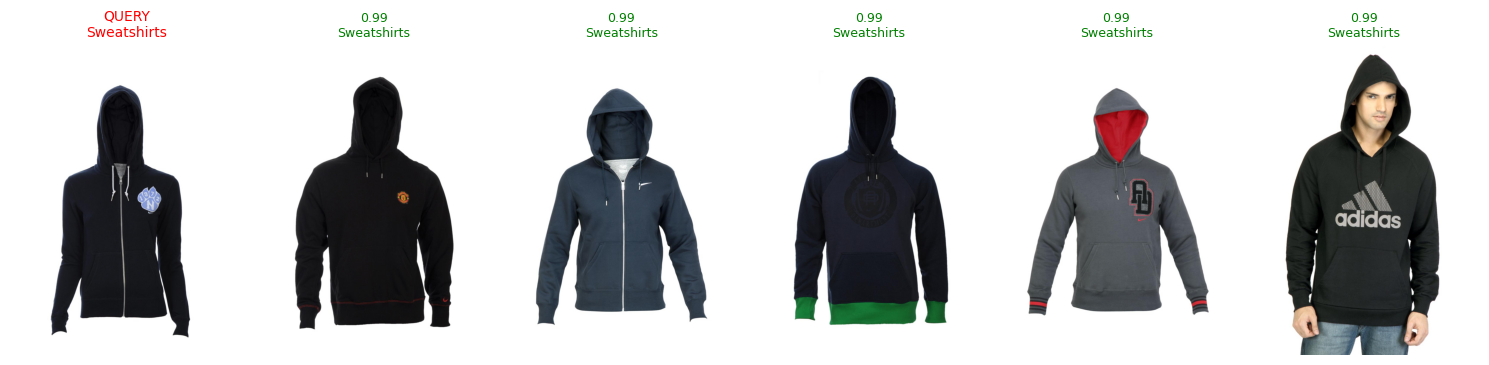


DONE! Check output files: loss_history.png, tsne_plot.png, retrieval_example_*.png


In [7]:
# ==========================================
# 6. MAIN EXECUTION
# ==========================================

if __name__ == "__main__":
    # --- CONFIG ---
    DATA_DIR = '/kaggle/input/fashion-product-text-images-dataset'
    IMG_DIR = os.path.join(DATA_DIR, 'data')
    CSV_PATH = os.path.join(DATA_DIR, 'data.csv')
    BATCH_SIZE = 32
    EPOCHS = 6 # Tăng lên 10 nếu có thời gian
    LR = 1e-4
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using Device: {DEVICE}")

    # --- DATA PREP ---
    print("Loading & Cleaning Data...")
    df = pd.read_csv(CSV_PATH)
    df = df.dropna(subset=['image', 'display name', 'description', 'category'])
    
    # Lọc ảnh tồn tại
    exists = [os.path.exists(os.path.join(IMG_DIR, r['image'])) for _, r in df.iterrows()]
    df = df[exists].reset_index(drop=True)
    
    # Lọc category >= 4 samples (cho Triplet Loss & Split)
    cnt = df['category'].value_counts()
    df = df[df['category'].isin(cnt[cnt >= 4].index)].copy()
    
    le = LabelEncoder()
    df['label_idx'] = le.fit_transform(df['category'])
    print(f"Data ready: {len(df)} items, {len(le.classes_)} classes.")
    
    train_df, val_df = train_test_split(df, test_size=0.15, stratify=df['category'], random_state=42)
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    
    train_loader = DataLoader(FashionDataset(train_df, IMG_DIR, tokenizer, transform=get_transforms(True)),
                              batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=2)
    val_loader = DataLoader(FashionDataset(val_df, IMG_DIR, tokenizer, transform=get_transforms(False)),
                            batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
    
    # --- MODEL & OPTIMIZER ---
    model = TwoTowerModel().to(DEVICE)
    criterion = BatchHardTripletLoss(margin=0.3)
    
    optimizer = optim.AdamW([
        {'params': model.image_encoder.parameters(), 'lr': LR * 0.1}, # Backbone học chậm
        {'params': model.text_encoder.parameters(), 'lr': LR * 0.1},
        {'params': model.image_proj.parameters(), 'lr': LR},          # Head học nhanh
        {'params': model.text_proj.parameters(), 'lr': LR},
        {'params': model.fusion.parameters(), 'lr': LR}
    ], weight_decay=1e-4)
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

    # --- TRAINING LOOP ---
    train_hist, val_hist = [], []
    best_loss = float('inf')
    
    print("\nSTART TRAINING...")
    for epoch in range(EPOCHS):
        # Freeze/Unfreeze Strategy
        if epoch < 2:
            model.set_backbone_trainable(False)
            print(f"Epoch {epoch+1}: Backbone Frozen")
        else:
            model.set_backbone_trainable(True)
            print(f"Epoch {epoch+1}: Backbone Unfrozen")
            
        t_loss = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
        v_loss = validate(model, val_loader, criterion, DEVICE)
        
        train_hist.append(t_loss)
        val_hist.append(v_loss)
        scheduler.step(v_loss)
        
        print(f"Epoch {epoch+1} | Train Loss: {t_loss:.4f} | Val Loss: {v_loss:.4f}")
        
        if v_loss < best_loss:
            best_loss = v_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print(">>> Model Saved!")

    # --- EVALUATION ---
    print("\nBUILDING EMBEDDINGS & EVALUATING...")
    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()
    
    full_ds = FashionDataset(df, IMG_DIR, tokenizer, transform=get_transforms(False))
    full_loader = DataLoader(full_ds, batch_size=64, shuffle=False, num_workers=2)
    
    all_embs, all_lbls = [], []
    with torch.no_grad():
        for batch in tqdm(full_loader):
            images = batch['image'].to(DEVICE)
            input_ids = batch['input_ids'].to(DEVICE)
            mask = batch['attention_mask'].to(DEVICE)
            emb = model(images, input_ids, mask)
            all_embs.append(emb.cpu().numpy())
            all_lbls.extend(batch['label'].numpy())
            
    all_embs = np.vstack(all_embs)
    all_lbls = np.array(all_lbls)
    
    # Calculate Metrics
    met = calculate_metrics(all_embs, all_lbls)
    print("\nFINAL METRICS:")
    for k, v in met.items():
        print(f"{k}: {v:.4f}")
        
    # Visualize
    visualize_results(train_hist, val_hist, all_embs, all_lbls, df, IMG_DIR, le)
    print("\nDONE! Check output files: loss_history.png, tsne_plot.png, retrieval_example_*.png")